# MonReader

Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

- Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

- Goal(s):

Predict if the page is being flipped using a single image.

- Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Read Data

In [2]:
labels = ['flip', 'notflip']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
train = get_data(os.path.join(os.getcwd(), 'images/training'))
test = get_data(os.path.join(os.getcwd(), 'images/testing'))

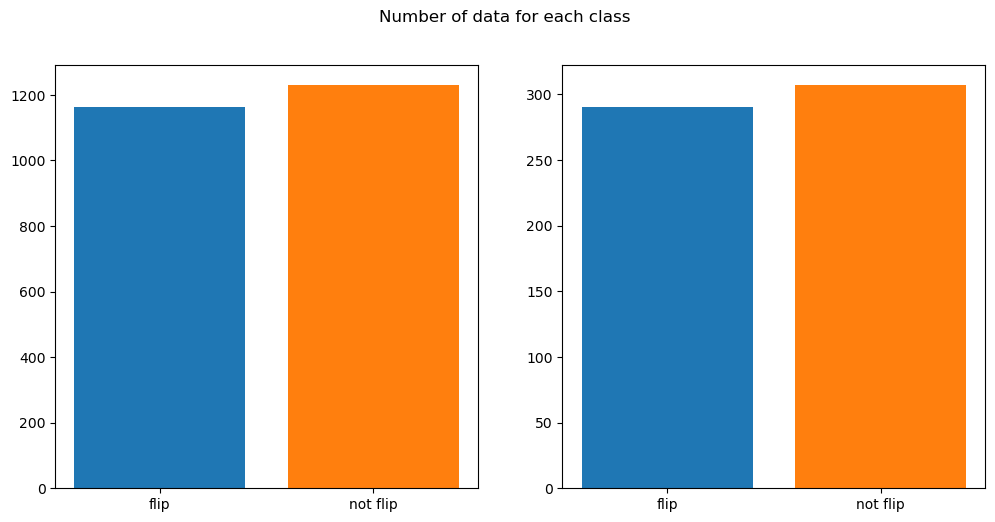

In [4]:
train_y, test_y = [], []
train_count0, train_count1, test_count0, test_count1 = 0, 0, 0, 0
for i in train:
    if(i[1] == 0):
        train_y.append("flip")
        train_count0 += 1
    else:
        train_y.append("not flip")
        train_count1 += 1
for i in test:
    if(i[1] == 0):
        test_y.append("flip")
        test_count0 += 1
    else:
        test_y.append("not flip")
        test_count1 += 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
fig.suptitle('Number of data for each class')
axes[0].bar(['flip', 'not flip'], [train_count0, train_count1], color=['C0', 'C1'])
axes[1].bar(['flip', 'not flip'], [test_count0, test_count1], color=['C0', 'C1'])
plt.show()

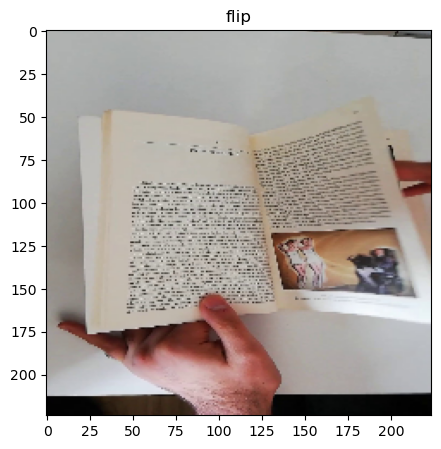

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

## Data Preprocessing and Data Augmentation

In [6]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

Normalize the input data

In [7]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## CNN model 

Define a three layer CNN model with alternate max-pooling layer. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.

In [8]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

## Model training

Compile the model using Adam as optimizer and SparseCategoricalCrossentropy as the loss function.

In [9]:
optimizer = Adam()
model.compile(optimizer=optimizer , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics=['accuracy'])

In [10]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-12-06 11:13:44.371599: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 36s 475ms/step - loss: 0.7750 - accuracy: 0.5878 - val_loss: 0.5566 - val_accuracy: 0.7672
Epoch 2/100
75/75 [==============================] - 29s 393ms/step - loss: 0.3639 - accuracy: 0.8474 - val_loss: 0.2653 - val_accuracy: 0.8978
Epoch 3/100
75/75 [==============================] - 30s 401ms/step - loss: 0.2061 - accuracy: 0.9193 - val_loss: 0.1833 - val_accuracy: 0.9296
Epoch 4/100
75/75 [==============================] - 31s 410ms/step - loss: 0.1320 - accuracy: 0.9515 - val_loss: 0.2927 - val_accuracy: 0.8961
Epoch 5/100
75/75 [==============================] - 30s 402ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.1049 - val_accuracy: 0.9631
Epoch 6/100
75/75 [==============================] - 30s 397ms/step - loss: 0.0626 - accuracy: 0.9783 - val_loss: 0.0850 - val_accuracy: 0.9665
Epoch 7/100
75/75 [==============================] - 30s 399ms/step - loss: 0.0445 - accuracy: 0.9849 - val_loss: 0.0355 - val_accuracy: 0.9883
Epoc

75/75 [==============================] - 32s 424ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0271 - val_accuracy: 0.9966
Epoch 58/100
75/75 [==============================] - 32s 421ms/step - loss: 6.2204e-04 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9950
Epoch 59/100
75/75 [==============================] - 34s 452ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0315 - val_accuracy: 0.9950
Epoch 60/100
75/75 [==============================] - 32s 430ms/step - loss: 0.0189 - accuracy: 0.9925 - val_loss: 0.0286 - val_accuracy: 0.9866
Epoch 61/100
75/75 [==============================] - 34s 457ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.0270 - val_accuracy: 0.9950
Epoch 62/100
75/75 [==============================] - 31s 414ms/step - loss: 3.3461e-04 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9933
Epoch 63/100
75/75 [==============================] - 31s 418ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0425 - val_accurac

## Result (accuracy)

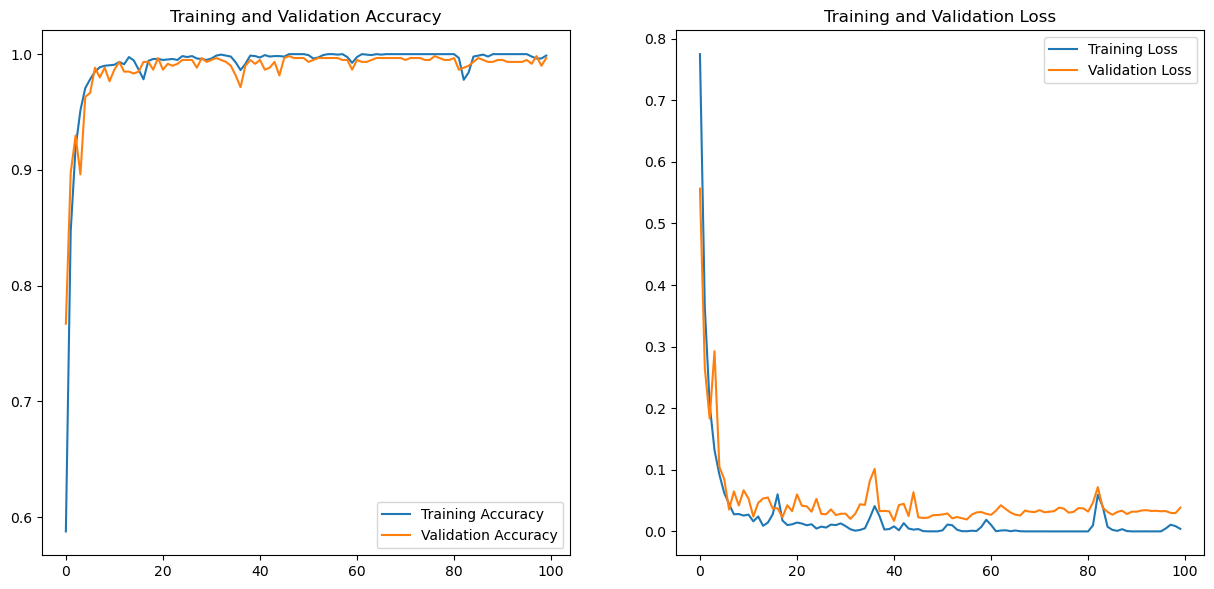

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion matrix

In [12]:
preds = [0 if x[0]>x[1] else 1 for x in model.predict(x_test)]

confusion_matrix(y_test, preds)

19/19 [==============================] - 2s 104ms/step


array([[288,   2],
       [  0, 307]])

In [13]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       290
           1       0.99      1.00      1.00       307

    accuracy                           1.00       597
   macro avg       1.00      1.00      1.00       597
weighted avg       1.00      1.00      1.00       597

